In [1]:
#!pip install Pillow
#!pip install tqdm

In [2]:
import os

import torch
from PIL import Image as PImage, ImageOps
import numpy as np
import pandas as pd
import string
from tqdm import tqdm

from IPython.display import Image
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = "D:\\ML\\Speech recognition\\NLP_diploma\\uk"

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.tsv"), sep="\t")
train_df = train_df[["path", "sentence"]]

def mp3_path_to_jpg_path(mp3_path):
    file_name = mp3_path.rsplit(".", 1)[0]
    file_name += ".jpg"
    path = os.path.join("train_spectrograms", file_name)
    return path

train_df["spectro_path"] = [mp3_path_to_jpg_path(row["path"]) for _, row in train_df.iterrows()]
train_df

,path,sentence,spectro_path
0,common_voice_uk_23566158.mp3,"Московитам дозволено створити свою державу, а ...",train_spectrograms\common_voice_uk_23566158.jpg
1,common_voice_uk_23566162.mp3,Патріарх Іоасаф визнав Івана царем і нащадком ...,train_spectrograms\common_voice_uk_23566162.jpg
2,common_voice_uk_23566225.mp3,Автор просить читачів звернути увагу на братів...,train_spectrograms\common_voice_uk_23566225.jpg
3,common_voice_uk_23566302.mp3,Це – незаперечна аксіома,train_spectrograms\common_voice_uk_23566302.jpg
4,common_voice_uk_23566305.mp3,"Ліпше чути заперечення мудрих, аніж підтакуван...",train_spectrograms\common_voice_uk_23566305.jpg
...,...,...,...
4030,common_voice_uk_23979850.mp3,— А що в тому саду видиш?,train_spectrograms\common_voice_uk_23979850.jpg
4031,common_voice_uk_23979853.mp3,— Хто ж несе мені сі слова від імператора захі...,train_spectrograms\common_voice_uk_23979853.jpg
4032,common_voice_uk_23979859.mp3,— Коней треба кувати.,train_spectrograms\common_voice_uk_23979859.jpg
4033,common_voice_uk_23979860.mp3,"— То є Пошогод, — шепнув Богданові Ждан. — Наш...",train_spectrograms\common_voice_uk_23979860.jpg


(256, 541)


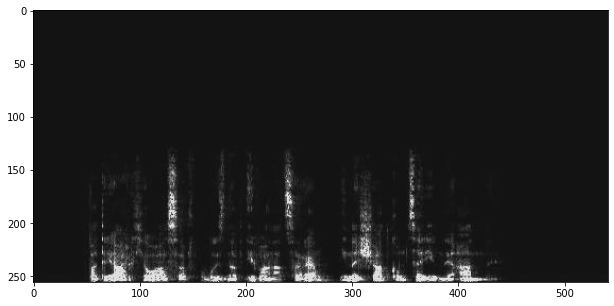

In [24]:
def img_to_array(data_dir, spectro_path, shape=None, fill=0):
    result = None
    img_path = os.path.join(data_dir, spectro_path)
    img = PImage.open(img_path)
    img = ImageOps.grayscale(img)
    if img and shape:
        result = np.zeros(shape) + fill
        arr = np.array(np.asarray(img))
        rows = arr.shape[0]
        cols = arr.shape[1]
        result[:rows, :cols] = arr
    elif img:
        result = np.array(np.asarray(img))
    return result

idx = 1
image_array = img_to_array(DATA_DIR, train_df.iloc[idx]["spectro_path"])
print(image_array.shape)

plt.figure(figsize=(12, 5))
plt.imshow(image_array, cmap=plt.get_cmap('gray')) 

# Кол-во занимаемых гигабайт при выделении памяти под тренировочный датасет

In [6]:
bytes_per_type = 4
bytes_ = 4035*256*1024*bytes_per_type
gb = bytes_ / 1024**3
gb 

3.9404296875

In [7]:
idx = 13
image_array = img_to_array(DATA_DIR, train_df.iloc[idx]["spectro_path"])
print(image_array.shape)

d_model = 1024
n_feats = image_array.shape[0]

inputs = np.zeros((len(train_df), n_feats, d_model), dtype="uint8")
inputs += 30 # is an empty space number in the spectrogram

for idx, spectro_path in enumerate(train_df["spectro_path"]):
    pixels = img_to_array(DATA_DIR, 
                          spectro_path, 
                          shape=(n_feats, d_model), 
                          fill=30)
    inputs[idx] = pixels
    
print(f"Inputs min: {min}")
print(f"Inputs shape: {inputs.shape}")

(256, 514)
Inputs min: <built-in function min>
Inputs shape: (4035, 256, 1024)


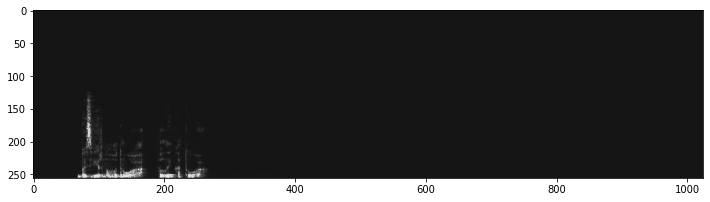

In [8]:
plt.figure(figsize=(12, 5))
plt.imshow(inputs[11], cmap=plt.get_cmap('gray')) 

In [9]:
embeddings_raw = pd.read_csv(os.path.join(DATA_DIR, "ubercorpus.lowercased.tokenized.word2vec.300d"), sep=" ")
embeddings_raw.shape

(538430, 301)

In [10]:
embeddings_raw.columns = ["word"] + [i for i in range(300)]
embeddings_raw = embeddings_raw.dropna(subset = ["word"])

words = []
for raw_word in embeddings_raw["word"]:
    try:
        w = raw_word.replace("'", "")
        w = raw_word.replace("’", "")
        words.append(w)
    except:
        print(raw_word, end="\t") 
embeddings_raw["word"] = words
embeddings_raw = embeddings_raw.drop_duplicates(subset=["word"])
print("Total words:", len(embeddings_raw))
print("Unique words:", embeddings_raw["word"].nunique())
embeddings_raw.columns

Total words: 538428
Unique words: 538428


Index(['word',      0,      1,      2,      3,      4,      5,      6,      7,
            8,
       ...
          290,    291,    292,    293,    294,    295,    296,    297,    298,
          299],
      dtype='object', length=301)

In [11]:
print(embeddings_raw.columns)
embeddings = embeddings_raw.set_index("word")
embeddings.index

Index(['word',      0,      1,      2,      3,      4,      5,      6,      7,
            8,
       ...
          290,    291,    292,    293,    294,    295,    296,    297,    298,
          299],
      dtype='object', length=301)


Index(['на', 'у', 'і', 'з', 'що', 'не', 'до', 'за', 'та', 'про',
       ...
       'припустимість', 'сальниця', 'pontificalis', 'хазе', 'арумом',
       'аксонеми', 'autoit', 'теперiшнього', 'потроїли', 'гусаром'],
      dtype='object', name='word', length=538428)

In [12]:
alphabet = ['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 
        'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 
        'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 
        'ш', 'щ', 'ь',  'ю', 'я',
        'є', 'і', 'ї', 'ґ']
emb_copy = embeddings.copy()
print("Embeddings shape before cleaning:", emb_copy.shape)
idxs = embeddings.index
for word in tqdm(idxs):
    for c in word:
        if c not in alphabet:
            emb_copy = emb_copy.drop(word)
            break
print("Embeddings shape after cleaning:", emb_copy.shape)
emb_copy.to_csv(os.path.join(DATA_DIR, "clean.lowercased.tokenized.word2vec.300d.csv"))

Embeddings shape before cleaning: (538428, 300)


  0%|▍                                                                                                                                                                                            | 1327/538428 [00:42<4:45:16, 31.38it/s]


KeyboardInterrupt: 

KeyboardInterrupt: 

In [14]:
"компютерні" in embeddings.index

False

In [15]:
def remove_stop_signs(sentence):
    stop_signs = string.punctuation + "–—»«…“”’"
    for sign in stop_signs:
        sentence = sentence.replace(sign, "")
    return sentence
    

def sentece_to_embeddings(sentence, embs, shape=None):
    """
    shape is a tuple:
        first value is an embedding dim
        second value is an maximum words dim
    """
    result = None
    missed_words = []
    sent = sentence.lower()
    sent = remove_stop_signs(sent)    
    tokens = sent.split()
    tokens = tokens.remove("") if "" in tokens else tokens
    if not shape:
        shape = (embs.shape[1], len(tokens))
    result = np.zeros(shape)
    for idx, word in enumerate(tokens):
        if word in embs.index:
            result[:, idx] = embs.loc[word]
        else:
            result[:, idx] = np.zeros(shape[0]) - 10
            missed_words.append(word)
    return result, missed_words

sent_to_embs, missed_words = sentece_to_embeddings(train_df["sentence"].loc[0], embeddings)
print("Result shape:", sent_to_embs.shape)
print("Missed words:", missed_words)

Result shape: (300, 12)
Missed words: []


In [16]:
missed_words = []
for sent in tqdm(train_df["sentence"]):
    _, mw = sentece_to_embeddings(sent, embeddings)
    missed_words += mw
print(f"Total missed words {len(missed_words)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4035/4035 [00:01<00:00, 3487.71it/s]

Total missed words 1954


In [17]:
for i in set(missed_words):
    print(i, end="\t")

чочого	міжповерхами	печалями	умикну	княжно	завбiльшки	риче	поплескала	слаава	розбійне	заград	страши	острижений	опрощення	бють	підсидів	проговорилися	знестями	гнусяться	кугутом	сексуалізований	ожвавився	облитого	передражнив	серебляних	пятдесят	будьякому	лiсосмуги	колис	бабский	повилуплювали	синьожовтий	несмачне	примолилася	спять	женить	клiпати	вигризти	сміяласи	освятиться	бється	славитьсябо	обєднань	сарський	обєкти	рiшив	юдоль	повідаєш	клянися	грекові	вузду	здурити	бє	контурну	валентиніанової	обличителя	пророблялося	остой	кавярні	огняном	максимиліаном	південносхідної	такего	пята	мещерки	інтерєр	жонити	зайдь	розпашілого	ротику	візьміте	декоторі	кіноцитат	ардарік	москалi	словіни	рішимість	трусивсь	сацьких	зачнете	застрашливої	годжусь	ясновидин	кревну	наждака	тягайся	нежинню	гречином	розтаскувати	вісімнадесять	затрепетав	підупалих	словянських	вишато	відкупишся	втікаєш	кварті	пiднесли	порусинському	вгамувалась	поробошні	волошкового	ізяславичі	компаніямпереробникам	вишаті	медовожовтий	велико

In [18]:
a = ["a", "", "b"]

a.remove("")
a

['a', 'b']

In [19]:
a = "123"
a.isnumeric()

True

In [20]:
a = train_df["sentence"].loc[0]

for sign in string.punctuation:
    a = a.replace(sign, "")
a

'Московитам дозволено створити свою державу а татарам чеченцям – ні Але це – расизм'

In [21]:
train_df["sentence"].loc[0]

'Московитам дозволено створити свою державу, а татарам, чеченцям – ні? Але це – расизм!'

In [22]:
a = "123, 0"
a.replace("6", "")

'123, 0'

In [23]:
syms = """
'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'є',
 'і',
 'ї',
"""

syms = syms.split(",\n")
syms = [c.replace("'", "").replace(" ", "").replace("\n", "") for c in syms]
for c in syms:
    print(f"'{c}', ", end="")
    
syms = ['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 
        'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 
        'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 
        'ш', 'щ', 'ь',  'ю', 'я',
        'є', 'і', 'ї', 'ґ']

'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'є', 'і', 'ї', '', 